In [1]:
import numpy as np
import pandas as pd
import building_blocks as lrb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Let's start by looking at an example with 3 teams.

## First, we simulate some games data.

In [9]:
# Set seed for reproducibility
np.random.seed(42)

# --- Step 1: Define teams and latent strengths ---
teams = ['A', 'B', 'C', 'D', 'E', 'F']
team_ids = {name: i for i, name in enumerate(teams)}
true_betas = np.array([0.05, 0.04, 0.03, -0.00, -0.01, -0.02])  # (note: we should try out different signal levels later).


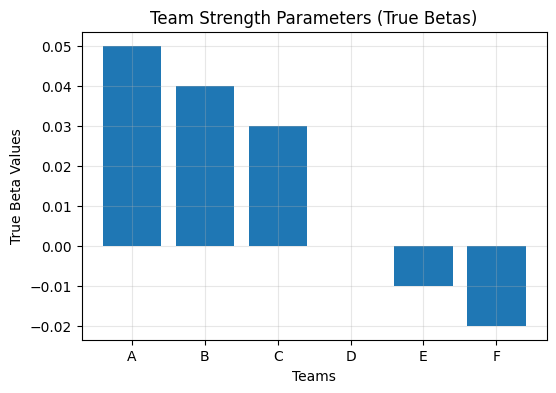

In [10]:
# create a plot of the true betas against team names.
plt.figure(figsize=(6, 4))
plt.bar(teams, true_betas)
plt.xlabel('Teams')
plt.ylabel('True Beta Values')
plt.title('Team Strength Parameters (True Betas)')
plt.grid(True, alpha=0.3)
plt.show()



In [11]:
# --- Step 2: Simulate 1000 random matchups ---
n_games = 1000
matchups = []

for _ in range(n_games):
    i, j = np.random.choice(3, size=2, replace=False) # randomly choose 2 teams to compete.
    beta_diff = true_betas[i] - true_betas[j]
    prob_win_i = 1 / (1 + np.exp(-beta_diff))
    winner = i if np.random.rand() < prob_win_i else j
    matchups.append((i, j, winner))

In [ ]:
### Plot beta in chatbot arena.
### Put big gap between top and second.
### What happens if the team never loses? -- the team's beta will be driven to infinity.

In [12]:
# --- Step 3: Create design matrix and outcome vector ---
X = np.zeros((n_games, 2))  # We fix beta_0 = 0 and estimate beta_1 and beta_2.
y = np.zeros(n_games)

for idx, (i, j, winner) in enumerate(matchups):
    # Map to reduced index space (beta_0 = 0)
    def reduced(k): return k - 1 if k > 0 else None
    
    if winner == i:
        y[idx] = 1
        if reduced(i) is not None:
            X[idx, reduced(i)] += 1
            # print(f"i, reduced(i): {i, reduced(i)}")
        if reduced(j) is not None:
            X[idx, reduced(j)] -= 1
    else:
        y[idx] = 0
        if reduced(j) is not None:
            X[idx, reduced(j)] += 1
        if reduced(i) is not None:
            X[idx, reduced(i)] -= 1

In [13]:
# --- Step 4: Display the data ---
match_df = pd.DataFrame(matchups, columns=["team_i", "team_j", "winner"])
match_df["team_i"] = match_df["team_i"].map({v: k for k, v in team_ids.items()})
match_df["team_j"] = match_df["team_j"].map({v: k for k, v in team_ids.items()})
match_df["winner"] = match_df["winner"].map({v: k for k, v in team_ids.items()})
print("Match Outcomes:")
print(match_df[:5])

print("\nDesign Matrix X:")
print(X[:10])

print("\nOutcome Vector y:")
print(y[:10])

Match Outcomes:
  team_i team_j winner
0      A      B      B
1      A      B      B
2      A      B      A
3      B      A      A
4      A      B      A

Design Matrix X:
[[ 1.  0.]
 [ 1.  0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [ 0. -1.]
 [ 1. -1.]
 [ 0.  1.]
 [-1.  1.]
 [ 0. -1.]]

Outcome Vector y:
[0. 0. 1. 0. 1. 1. 1. 1. 0. 1.]


## Now, let's see if these rankings are robust to dropping just a little data.

#### Helpers, for now...

In [19]:
def compute_leverage(
    pos_p_hats: np.ndarray,
    X: np.ndarray,
    index: int,
    y: np.ndarray,
) -> float:
    """
    pos_p_hats: np.array, shape (n,), the predicted probabilities.
    X: np.array, shape (n, p), the design matrix.
    index: int, the index of the data point whose influence we want to compute.
    y: np.array, shape (n,), the response variable.

    Compute the leverage of the index-th data point.
    """
    v_lst = pos_p_hats * (1 - pos_p_hats)
    V = np.diag(v_lst)
    H = V @ X @ np.linalg.inv(X.T @ V @ X) @ X.T
    return H[index, index]

def compute_approx(
    pos_p_hats: np.ndarray,
    X: np.ndarray,
    index: int,
    y: np.ndarray,
    method: str,
    e: np.ndarray,
) -> float:
    """
    pos_p_hats: np.array, shape (n,), the predicted probabilities.
    X: np.array, shape (n, p), the design matrix.
    index: int, the index of the data point whose influence we want to compute.
    y: np.array, shape (n,), the response variable.
    method: str, the method to use to compute the approximation ("1sN" or "IF").
    e: np.ndarray, shape (p,), the direction of the influence function.

    Compute the influence function approximation of
    the effect of infinitesimally upweighting the index-th
    data point on a quantity of interest 
    (e.g., some linear combination of the 
    logistic regression coefficients,
    determined by the choice of e).
    """
    v_lst = pos_p_hats * (1 - pos_p_hats)
    V = np.diag(v_lst)
    if method == "IF":
        influence_function = (
            e @ np.linalg.inv(X.T @ V @ X) @ X[index] * (y[index] - pos_p_hats[index])
        ) # solve linear system rather than inverting matrix.
        return influence_function[0]
    elif method == "1sN":
        influence_function = (
            e @ np.linalg.inv(X.T @ V @ X) @ X[index] * (y[index] - pos_p_hats[index])
        )
        h_ii = compute_leverage(pos_p_hats, X, index, y)
        return 1 / (1 - h_ii) * influence_function[0]
    else:
        return "Invalid method."

### Fit a logistic regression model to the full data.

In [20]:
full_model = lrb.run_logistic_regression(X, y)
full_model.coef_[0]

array([-0.05874159, -0.04137445])

In [21]:
# report coefficients.
betaA_full, betaB_full = full_model.coef_[0]
print(f'The original beta_A is {betaA_full}.')
print(f'The original beta_B is {betaB_full}.')

The original beta_A is -0.05874159142864451.
The original beta_B is -0.04137444666699011.


In [22]:
# report the predicted probabilities.
pos_p_hats = full_model.predict_proba(X)[:, 1]
pos_p_hats[:5]

array([0.48531882, 0.48531882, 0.51468118, 0.51468118, 0.51468118])

In [23]:
# this is the direction (in parameter space) that the influence score is computed for.
e_A = np.array([1, 0]).reshape(1, 2) # for beta_A > 0
print(e_A.shape)
e_AminusB = np.array([1, -1]).reshape(1, 2) # for beta_A > beta_B
print(e_AminusB.shape)

(1, 2)
(1, 2)


In [24]:
index = 1
v_lst = pos_p_hats * (1 - pos_p_hats)
V = np.diag(v_lst)
# a vector of size num dimension (e.g., num teams - 1)
np.linalg.inv(X.T @ V @ X) @ X[index] * (y[index] - pos_p_hats[index])

array([-0.00406429, -0.00206754])

### Approximately how many games need to be dropped for $\beta_A > 0$ to no longer hold?
conclusion: $\beta_A > 0$ ends up being super robust to data dropping in this simulation.

In [25]:
# how many data points must be dropped to change beta_A.
scores = []
# compute the influence scores for all points.
for ind in range(1, len(X)):
    score_i = compute_approx(pos_p_hats, X, ind, y, "1sN", e_A)
    scores.append(score_i)
scores[:5]

[-0.004072809929398967,
 -0.004072809929398967,
 0.004319219665743556,
 -0.004072809929398967,
 -0.0020901598226093004]

In [26]:
# sort indices in ascending order.
inds = np.argsort(scores)
scores_array = np.array(scores)
scores_array[inds][:5]

array([-0.00407281, -0.00407281, -0.00407281, -0.00407281, -0.00407281])

In [27]:
k = 20
print(f'The original beta_A is {betaA_full}.')
print(f'The 1sN approximation to the effect of dropping the worst case {k} points is {betaA_full - sum(scores_array[inds[:k]])}.')

The original beta_A is -0.05874159142864451.
The 1sN approximation to the effect of dropping the worst case 20 points is 0.022714607159334828.


In [28]:
# Gets all influence scores after index k in ascending order.
# These are the scores we'll keep after dropping k most influential points.
print(f'The first 5 scores are {scores_array[inds][:5]}.')
print(f'The last 5 scores are {scores_array[inds][-5:]}.')


The first 5 scores are [-0.00407281 -0.00407281 -0.00407281 -0.00407281 -0.00407281].
The last 5 scores are [0.00431922 0.00431922 0.00431922 0.00431922 0.00431922].


In [30]:
# get all of the X's and y's that we're keeping.
X_new = X[~np.isin(range(len(X)), inds[:k])]
y_new = y[~np.isin(range(len(y)), inds[:k])]
X_new.shape, y_new.shape

((980, 2), (980,))

In [31]:
# refit the logistic regression model.
refit_model = lrb.run_logistic_regression(X_new, y_new)
refit_model


LogisticRegression(fit_intercept=False, penalty=None)

In [32]:
# report coefficients.
betaA_refit, betaB_refit = refit_model.coef_[0]
print(f'The refit beta_A is {betaA_refit}.')
print(f'The refit beta_B is {betaB_refit}.')

The refit beta_A is -0.047269450482963486.
The refit beta_B is -0.047238119731685325.


In [33]:
print(f'The original beta_A is {betaA_full}.')
print(f'After dropping {k} points, the refit of beta_A is {refit_model.coef_[0][0]}.')
# interestingly, the refit value is very different from the 1sN approximation
# to the refit. wondering if has to do with the BT model setup (the design matrix in particular).

The original beta_A is -0.05874159142864451.
After dropping 20 points, the refit of beta_A is -0.047269450482963486.


In [43]:
# let's try a larger value of points to drop.
k = 50

# get all of the X's and y's that we're keeping.
X_new = X[~np.isin(range(len(X)), inds[:k])]
y_new = y[~np.isin(range(len(y)), inds[:k])]
X_new.shape, y_new.shape

# refit the logistic regression model.
refit_model = lrb.run_logistic_regression(X_new, y_new)
refit_model

# report coefficients.
betaA_refit, betaB_refit = refit_model.coef_[0]
print(f'The refit beta_A is {betaA_refit}.')

# it seems like the sign of beta_A is very robust to dropping points.

The refit beta_A is -0.044679383607608675.


### Approximately how many games need to be dropped for $\beta_A > \beta_B$ to no longer hold?

Conclusion: 50 data point (5% of the data) can be dropped for this inequality to flip.

In [44]:
# how many data points must be dropped to change beta_A - beta_B
scores = []
# compute the influence scores for all points.
for ind in range(1, len(X)):
    score_i = compute_approx(pos_p_hats, X, ind, y, "1sN", e_AminusB)
    scores.append(score_i)
scores[:5]

[-0.0020009356979932566,
 -0.002000935697993256,
 0.002121994634288316,
 -0.002000935697993256,
 0.0017935272386674073]

In [45]:
# sort indices in ascending order.
inds = np.argsort(scores)
scores_array = np.array(scores)
scores_array[inds][:5]

array([-0.0038587, -0.0038587, -0.0038587, -0.0038587, -0.0038587])

In [46]:
k = 50
print(f'The original (beta_A - beta_B) is {betaA_full - betaB_full}.')
print(f'After dropping {k} points, the 1sN score estimate of (beta_A - beta_B) is {(betaA_full - betaB_full) + sum(scores_array[inds[k:]])}.')

The original (beta_A - beta_B) is -0.0173671447616544.
After dropping 50 points, the 1sN score estimate of (beta_A - beta_B) is 0.17757277283283607.


#### Refit with the points dropped.

In [47]:
# get all of the X's and y's that we're keeping.
X_new = X[~np.isin(range(len(X)), inds[:k])]
y_new = y[~np.isin(range(len(y)), inds[:k])]
X_new.shape, y_new.shape

((950, 2), (950,))

In [48]:
# refit the logistic regression model.
refit_model = lrb.run_logistic_regression(X_new, y_new)
refit_model

LogisticRegression(fit_intercept=False, penalty=None)

In [49]:
# report coefficients.
betaA_refit, betaB_refit = refit_model.coef_[0]


In [51]:
print(f'The original (beta_A - beta_B) is {betaA_full - betaB_full}.')
print(f'After dropping {k} points, the refit of (beta_A - beta_B) is {refit_model.coef_[0][0] - refit_model.coef_[0][1]}.')

The original (beta_A - beta_B) is -0.0173671447616544.
After dropping 50 points, the refit of (beta_A - beta_B) is 0.014395111003527652.
